In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
## Read file
df_allsamp = pd.read_csv("samples_UCEC_sig_labels.csv")

In [3]:
## Construct individual df 
df_POLE = df_allsamp[df_allsamp['Hugo_Symbol']=="POLE"].reset_index(drop=True)
df_POLD1 = df_allsamp[df_allsamp['Hugo_Symbol']=="POLD1"].reset_index(drop=True)

# get unique tumor_sample_barcode with POLE and POLD1 gene mutation 
unique_samples_POLE = np.unique(df_POLE['Tumor_Sample_Barcode'])
unique_samples_POLD1 = np.unique(df_POLD1['Tumor_Sample_Barcode'])

In [22]:
len(unique_samples_POLD1)

36

## Initial analysis methods

In [22]:
# group samples based on their label (driver, potential driver or passenger), and observe the type of mutational signatures present in each. 

## MODIFY THIS EQUATION: label is different for each of the mutation, removing duplicated samples will remove this mutation difference
## that identifies the muttion. 
def graph_mutsig_exposure_by_label(df, label): 
    '''available label options: "Driver", "Potential driver", "Passenger", "NaN"''' 

    # find unique samples based on lable 
    if label=="": 
        df_sub = df
    else: 
        df_sub = df[df['label'] == label]
    
    if df_sub.shape[0] == 0: 
        print("number of rows = 0 for this label. ")
        return df_sub 

    df_sub = df_sub.drop_duplicates(subset = ["Tumor_Sample_Barcode"])
    
    filter_col = ["Tumor_Sample_Barcode"] + [col for col in df_sub if col.startswith('COSMICv3')]
    
    sig_exp = df_sub[filter_col].T
    sig_exp = sig_exp.rename(columns=sig_exp.iloc[0])
    sig_exp = sig_exp.drop(sig_exp.index[0])

    num_samp = len(np.unique(df['Tumor_Sample_Barcode']))

    # sig_sums = sig_exp.sum(axis=0).replace(0, 1)
    # sig_exp = sig_exp.div(sig_sums, axis=0)
    sig_exp = sig_exp/num_samp
    
    sig_exp.plot(kind="bar",stacked=True,figsize=(16,8))
    plt.title("Averaged mutational signature exposures in cluster")
    plt.legend(loc="lower right", bbox_to_anchor=(0.8,0, 0.5, 0.5))
    # plt.legend(loc="best")
    plt.show()

    # return df_sub

In [5]:
# For each gene, group the samples based on signatures and observe the mutation distributions. 
def find_mutation_by_signature(df, signature): 
    '''available label options: "Driver", "Potential driver", "Passenger", "NaN"''' 

    # find unique samples based on lable 
    df_sub = df.sort_values(signature, ascending=False)
    df_sub = df_sub[['Hugo_Symbol','Tumor_Sample_Barcode', 'HGVSp_Short', 'label', 'mutability', 'bscore', signature]]

    # find top 20% mutation based on mutational signature exposure and label 
    df_sub = df_sub.dropna()
    top_x_rows = df_sub[:int(df_sub.shape[0]*0.2)] 

    mut_freq = df_sub['HGVSp_Short'].value_counts()
    mut_freq = pd.DataFrame.from_dict(mut_freq)
    mut_freq = mut_freq.rename(columns={'HGVSp_Short':'mutation_freq'})

    mut_freq['Driver'] = pd.Series(dtype=mut_freq['mutation_freq'].dtype)
    mut_freq['Potential driver'] = pd.Series(dtype=mut_freq['mutation_freq'].dtype)
    mut_freq['Passenger'] = pd.Series(dtype=mut_freq['mutation_freq'].dtype)
    mut_freq['nan'] = pd.Series(dtype=mut_freq['mutation_freq'].dtype)
    
    for index, row in mut_freq.iterrows():
        ind_mut = df.index.values[index==df['HGVSp_Short']]
        labels = []
        for i in ind_mut: 
            labels.append(df.iloc[i]['label'])
        label_freq = np.unique(np.array(labels), return_counts=True)

        for i in range(0,len(label_freq[0])): 
            mut_freq.loc[index, [label_freq[0][i]]] = label_freq[1][i]
        # mut_freq.at[index, 'label'] = df.iloc[ind_mut]['HGVSp_Short']


    return mut_freq

## Clustering of distribution
- For POLE gene and POLD1 gene
    1. Distribution of tSNE given the driver/non-driver status 
    2. Distribution of tSNE given the MSI status 
- For the entire UCEC genome 
    1. Distribution given mutated gene. 

In [6]:
# Project the X-dimension (x=number of sigfnatures) exposure data for each sample. 
# Do dimensionality reduction to visualize on the data on the 2D space. 
# tSNE (cluster plot seen on MutaGene) 

from sklearn import manifold

def project_signature_distribution(df, label, perplexity): 
    df_test = df.reset_index(drop=True)

    tSNE_embedding = manifold.TSNE(
        n_components=2,
        init="random",
        learning_rate="auto",
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
        perplexity=perplexity, 
    )

    sig_cols = [col for col in df_test.columns if 'COSMIC' in col]
    data = df_test.drop_duplicates(subset=["Tumor_Sample_Barcode"]) 
    y = data[label].to_numpy()
    y = np.array(['missing' if x is np.nan else x for x in y])
    data = data[sig_cols]
    data = np.nan_to_num(data.to_numpy())
    # print(data)
    # print(y)

    projection = tSNE_embedding.fit_transform(data, y)
    print(projection.shape)
    # print(projection)
    labs = np.unique(y)
    plt.figure(figsize=(12,8))
    for i,lab in enumerate(labs):
        lab_MSS = y == lab
        c = np.array([[float(i+1)/float(len(labs)), 0.6, float(len(labs)-i)/float(len(labs)), 1.0],])
        plt.scatter(projection[lab_MSS, 0], projection[lab_MSS, 1], c=c, label=lab)
    plt.legend()
    
    # return projection, labs

In [7]:
# Find cluster in a projection
def find_cluster_in_projection(df, label, perplexity, xlim, ylim): 
    df_test = df.reset_index(drop=True)

    tSNE_embedding = manifold.TSNE(
        n_components=2,
        init="random",
        learning_rate="auto",
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
        perplexity=perplexity, 
    )

    sig_cols = [col for col in df_test.columns if 'COSMIC' in col]
    data = df_test.drop_duplicates(subset=["Tumor_Sample_Barcode"])
    y = data[label].to_numpy()
    y = np.array(['missing' if x is np.nan else x for x in y])
    data_x = data[sig_cols]
    data_x = np.nan_to_num(data_x.to_numpy())
    # print(data)
    # print(y)

    projection = tSNE_embedding.fit_transform(data_x, y)
    # print(projection[:,0])
    projection_x = projection[:,0]
    projection_y = projection[:,1]
    temp1 = data[projection_x>xlim[0]]
    temp2 = data[projection_x<xlim[1]]
    temp3 = data[projection_y>ylim[0]]
    temp4 = data[projection_y<ylim[1]]
    data_within_lim = set(temp1["Tumor_Sample_Barcode"])&set(temp2['Tumor_Sample_Barcode'])&set(temp3["Tumor_Sample_Barcode"])&set(temp4['Tumor_Sample_Barcode'])
    # print(data_within_lim)

    return data_within_lim

In [8]:
def save_cluster(cluster, name): 
    df_maf = pd.read_csv('R-notebooks/ucec_maf.csv', index_col=[0])
    df_cluster = df_maf[df_maf['Tumor_Sample_Barcode'].isin(cluster)]
    df_cluster.reset_index(drop=True, inplace=True)
    df_cluster.to_csv(name, index=False)

In [9]:
def project_signature_distribution_highlight_samples(df, label, perplexity, highlight_samples): 
    df_test = df.reset_index(drop=True)

    tSNE_embedding = manifold.TSNE(
        n_components=2,
        init="random",
        learning_rate="auto",
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
        perplexity=perplexity, 
    )

    sig_cols = [col for col in df_test.columns if 'COSMIC' in col]
    data = df_test.drop_duplicates(subset=["Tumor_Sample_Barcode"]) 
    samples = data['Tumor_Sample_Barcode']
    y = data[label].to_numpy()
    y = np.array(['missing' if x is np.nan else x for x in y])
    data = data[sig_cols]
    data = np.nan_to_num(data.to_numpy())
    # print(data)
    # print(y)

    projection = tSNE_embedding.fit_transform(data, y)
    print(projection.shape)
    # print(projection)
    labs = np.unique(y)
    plt.figure(figsize=(12,8))
    for i,lab in enumerate(labs):
        inds_with_lab = y == lab
        c = np.array([[float(i+1)/float(len(labs)), 0.6, float(len(labs)-i)/float(len(labs)), 1.0],])
        plt.scatter(projection[inds_with_lab, 0], projection[inds_with_lab, 1], c=c, label=lab)
    plt.legend()

    for samp in highlight_samples: 
        c = 'r'
        ind = samples == samp
        plt.scatter(projection[ind, 0], projection[ind, 1], c=c, label="target_gene")
    
    # return projection, labs

## UCEC Distribution

(529, 2)


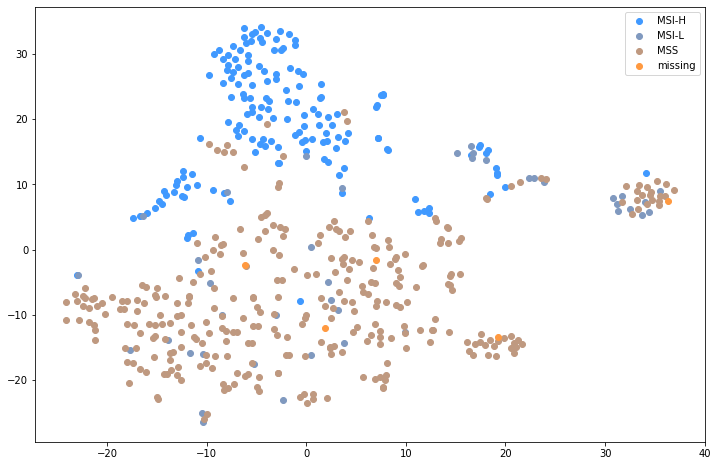

In [10]:
# Graph of all samples wrt MSI status
project_signature_distribution(df_allsamp, "MSI", perplexity=20)
### Point out the samples with POLE or POLD1 gene in this plot 

(529, 2)


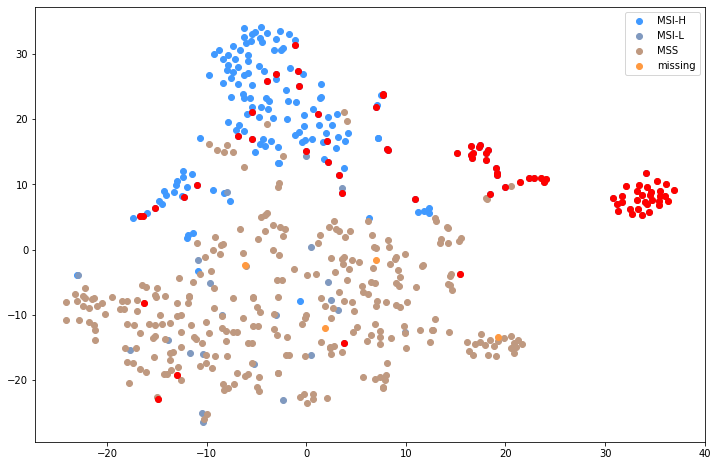

In [12]:
project_signature_distribution_highlight_samples(df_allsamp, "MSI", perplexity=20, highlight_samples=unique_samples_POLE)

(529, 2)


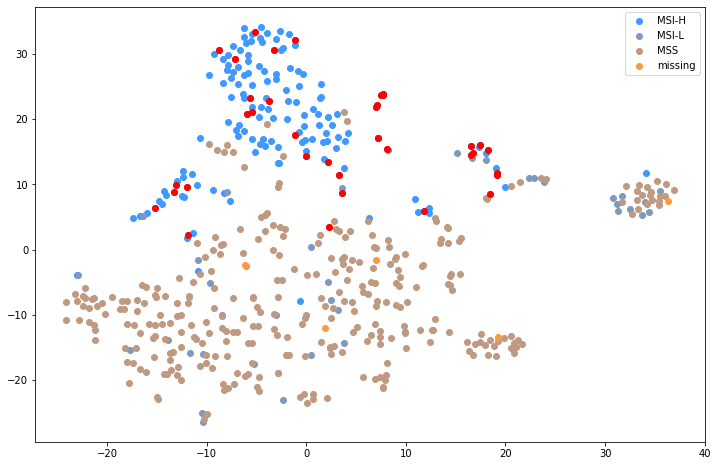

In [13]:
project_signature_distribution_highlight_samples(df_allsamp, "MSI", perplexity=20, highlight_samples=unique_samples_POLD1)

In [14]:
# cluster on the right 
cluster1 = find_cluster_in_projection(df_allsamp, "MSI", perplexity=20, xlim=[30,40], ylim=[0,20])

# save cluster to be analyzed in mutational profile. 
# save_cluster(cluster1, "cluster.csv")

## Open csv in Excel, and save as a Tab Delimited txt. Then rename file to .maf. 

## Get mutational profile: 
## mutagene profile --infile /Users/jessysong/Documents/Comp-Bio-Lab/cluster1_4.maf -o test_output_profile --genome /Users/jessysong/Documents/Comp-Bio-Lab/GRCh38.d1.vd1.2bit -f MAF

## Convert to csv by saving as .csv. Then separate column by tab + add column header. 

In [20]:
# MSI-H cluster 
cluster1_1 = find_cluster_in_projection(df_allsamp, "MSI", perplexity=20, xlim=[-20,15], ylim=[0,40])
# MSI-L cluster 
cluster1_2 = find_cluster_in_projection(df_allsamp, "MSI", perplexity=20, xlim=[-30,15], ylim=[-30,5])
# MSI-L specific cluster 
cluster1_3 = find_cluster_in_projection(df_allsamp, "MSI", perplexity=20, xlim=[15,25], ylim=[-20,-10])
# Y-shaped cluster 
cluster1_4 = find_cluster_in_projection(df_allsamp, "MSI", perplexity=20, xlim=[13,27], ylim=[5,20])

In [61]:
save_cluster(cluster1_4, "cluster1_4.csv")

/var/folders/55/cwx6q2h16k1f7mlmfr7md0hc0000gn/T/ipykernel_2999/3179425473.py:1: DtypeWarning: Columns (88,89,99,119) have mixed types.Specify dtype option on import or set low_memory=False.
  save_cluster(cluster1_4, "cluster1_4.csv")


/Users/jessysong/miniforge3/envs/env_mutagene/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Mutation', ylabel='Frequency'>

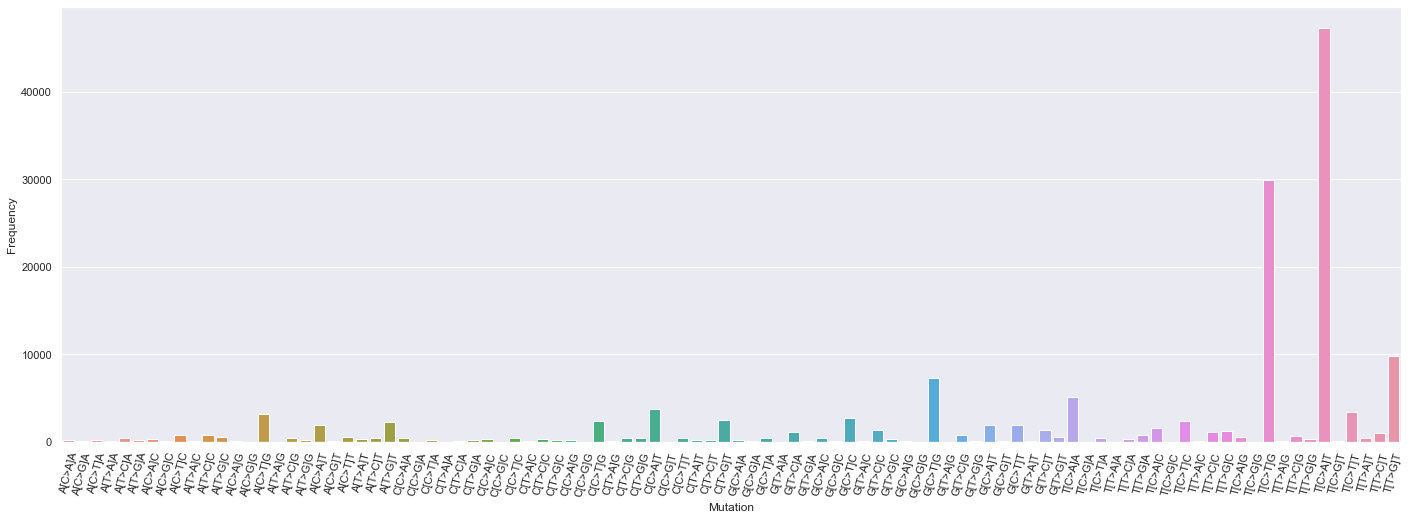

In [15]:
df_cluster_profile = pd.read_csv("clusters/cluster_profile.csv")
# df_cluster_profile

sns.set(rc = {'figure.figsize':(24,8)})
plt.xticks(rotation=75)
# sns.set(font_scale = 1.7)
sns.barplot(df_cluster_profile['Mutation'], df_cluster_profile['Frequency'])

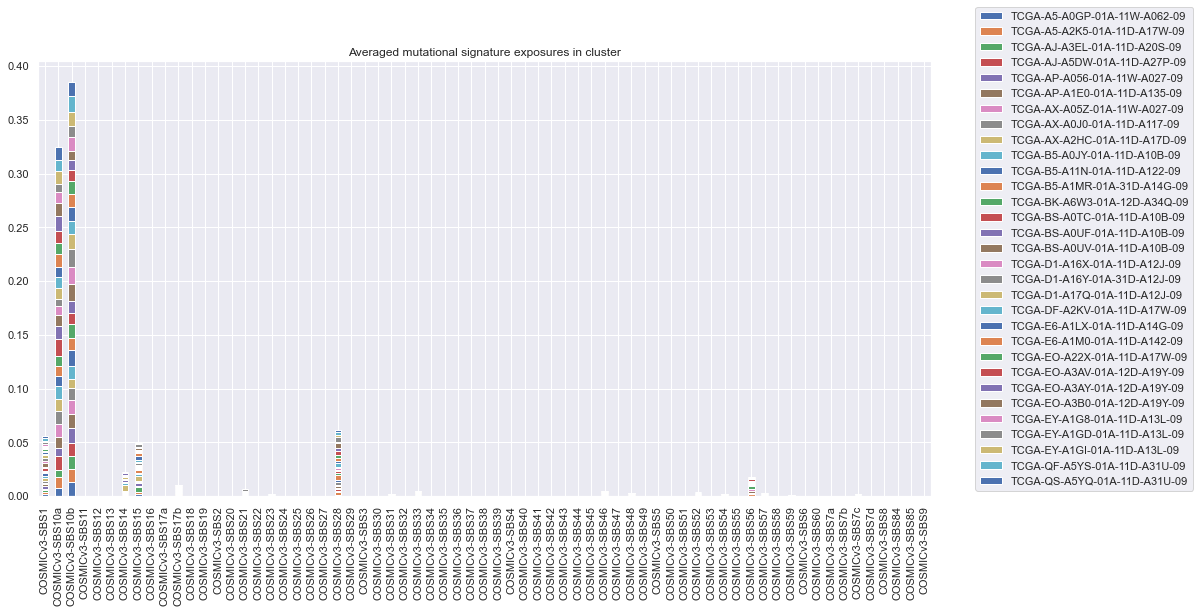

In [23]:
## Plot cluster signature exposures
df_cluster = df_allsamp[df_allsamp['Tumor_Sample_Barcode'].isin(cluster1)]
graph_mutsig_exposure_by_label(df_cluster, "") # when label not specified, get all sig exposures in all samples

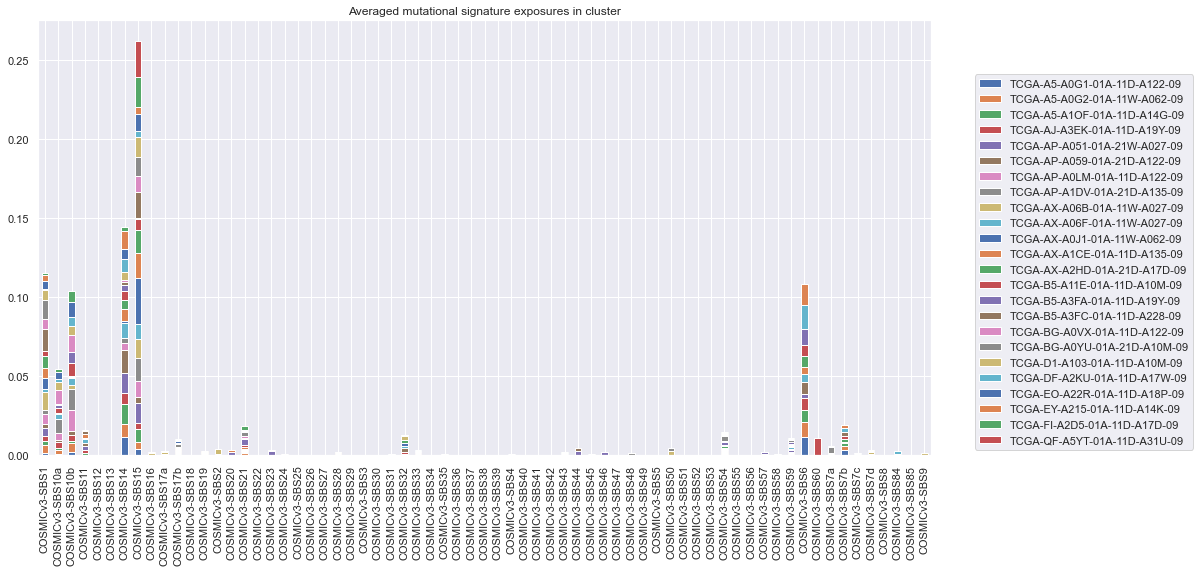

In [24]:
df_cluster = df_allsamp[df_allsamp['Tumor_Sample_Barcode'].isin(cluster1_4)]
graph_mutsig_exposure_by_label(df_cluster, "") # when label not specified, get all sig exposures in all samples

In [75]:
df_cluster = df_allsamp[df_allsamp['Tumor_Sample_Barcode'].isin(cluster1)]

In [81]:
df_cluster["COSMICv3-SBS28"]

35413     0.044225
35414     0.044225
35415     0.044225
35416     0.044225
35417     0.044225
            ...   
498718    0.066456
498719    0.066456
498720    0.066456
498721    0.066456
498722    0.066456
Name: COSMICv3-SBS28, Length: 154608, dtype: float64

/Users/jessysong/miniforge3/envs/env_mutagene/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Mutation', ylabel='Frequency'>

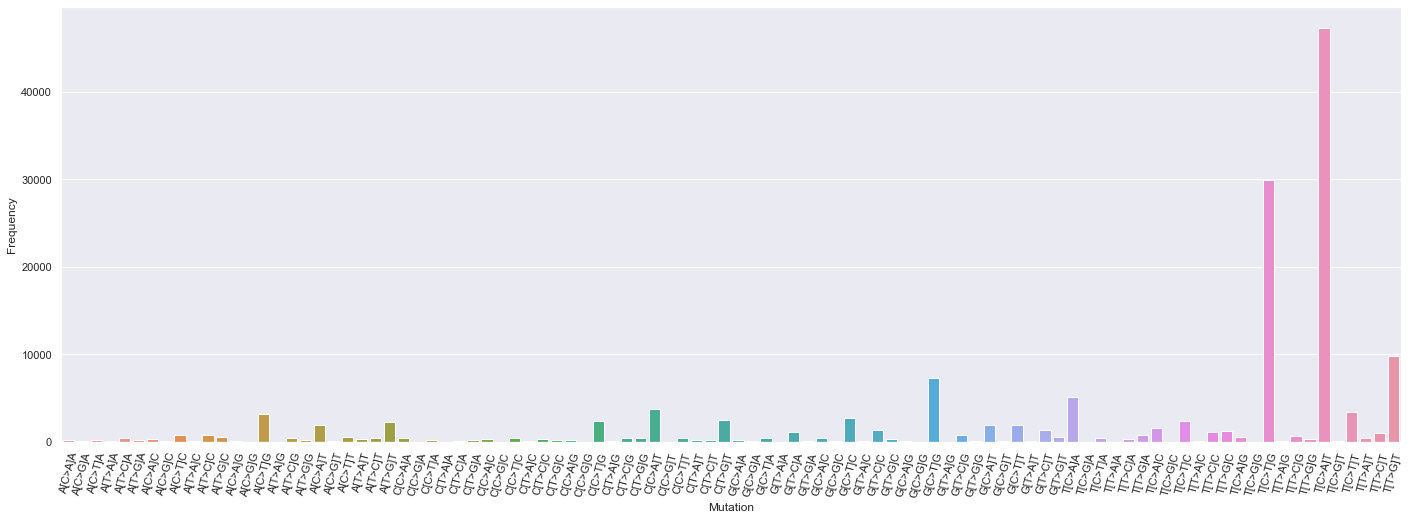

In [65]:
# Graph barplot of a cluster 
import seaborn as sns

df_cluster_profile = pd.read_csv("cluster_profile.csv")
# df_cluster_profile

sns.set(rc = {'figure.figsize':(24,8)})
plt.xticks(rotation=75)
# sns.set(font_scale = 1.7)
sns.barplot(df_cluster_profile['Mutation'], df_cluster_profile['Frequency'])

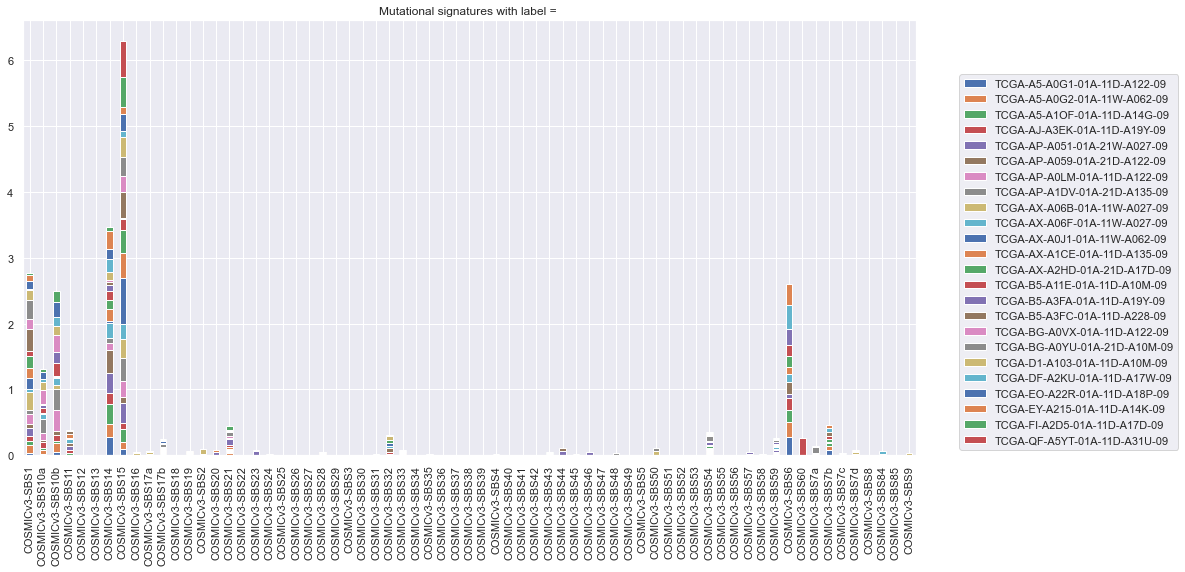

In [66]:
## Plot cluster signature exposures
df_cluster = df_allsamp[df_allsamp['Tumor_Sample_Barcode'].isin(cluster1_4)]
graph_mutsig_exposure_by_label(df_cluster, "") # when label not specified, get all sig exposures in all samples

(529, 2)


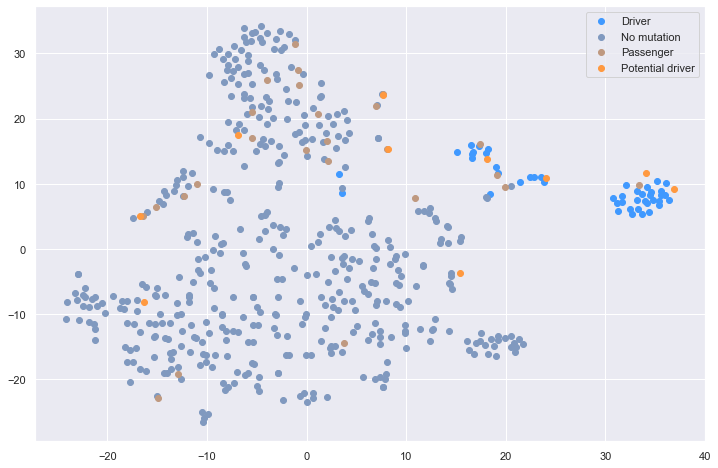

In [48]:
project_signature_distribution(df_allsamp, "PredPOLEDriverLabel", perplexity=20) 

(529, 2)


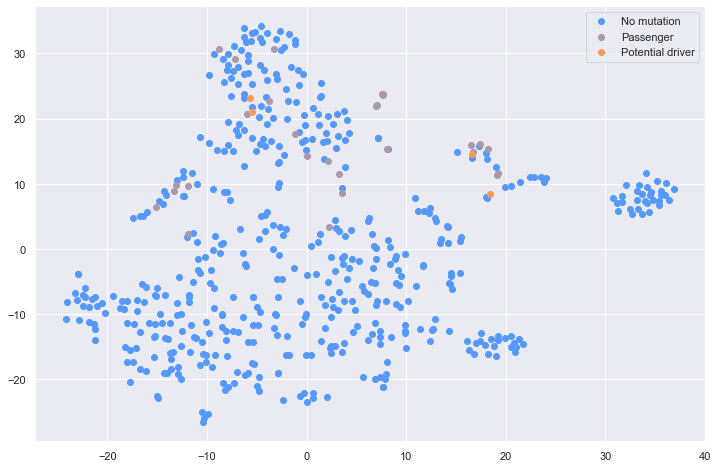

In [22]:
project_signature_distribution(df_allsamp, "PredPOLD1DriverLabel", perplexity=20)

In [21]:
# not too informative, since no mutation ones are already labeled
# project_signature_distribution_highlight_samples(df_allsamp, "PredPOLEDriverLabel", perplexity=20, highlight_samples=unique_samples_POLE)

(529, 2)


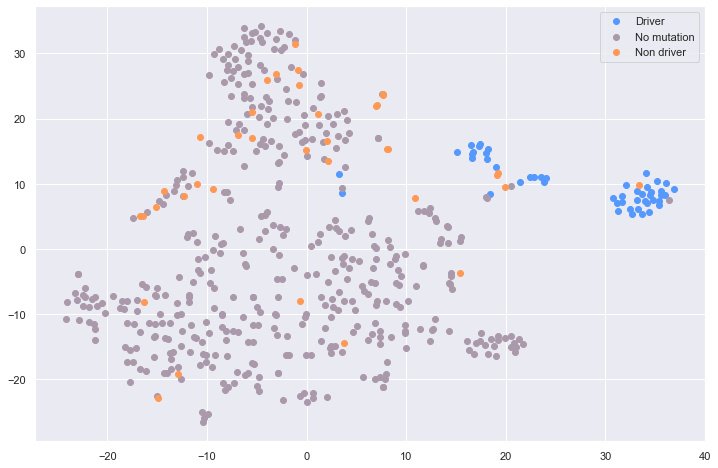

In [23]:
project_signature_distribution(df_allsamp, "ExpPOLEDriverLabel", perplexity=20)

(529, 2)


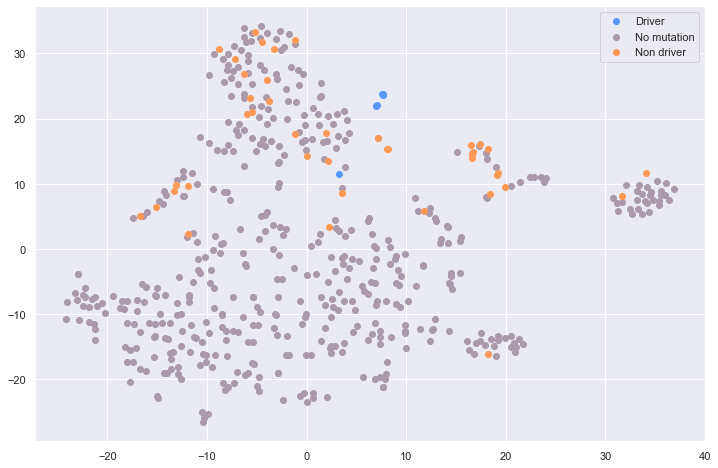

In [24]:
project_signature_distribution(df_allsamp, "ExpPOLD1DriverLabel", perplexity=20)

## Analysis of clinically selected group

In [25]:
df_samp_group1 = pd.read_csv('samples_group1_UCEC.csv')
samples_group1 = df_samp_group1['sample'].values

In [26]:
df_samp_group1 = df_allsamp[df_allsamp['Tumor_Sample_Barcode'].isin(samples_group1)]

In [27]:
df_POLE_samp_group1 = df_samp_group1[df_samp_group1['Hugo_Symbol']=="POLE"].reset_index(drop=True)
df_POLD1_samp_group1 = df_samp_group1[df_samp_group1['Hugo_Symbol']=="POLD1"].reset_index(drop=True)

(391, 2)


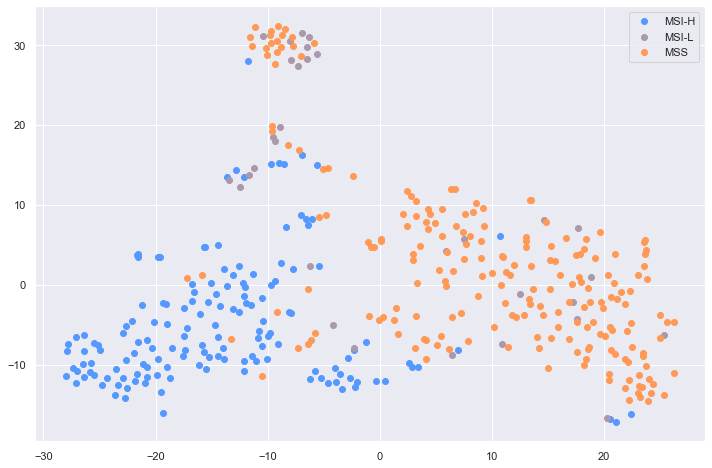

In [28]:
project_signature_distribution(df_samp_group1, "MSI", perplexity=20)

In [29]:
cluster2 = find_cluster_in_projection(df_samp_group1, "MSI", perplexity=20, xlim=[-20,0], ylim=[22,40])

# save cluster to be analyzed in mutational profile. 
# save_cluster(cluster2, "cluster2.csv")

## Open csv in Excel, and save as a Tab Delimited txt. Then rename file to .maf. 

## Get mutational profile: 
## mutagene profile --infile /Users/jessysong/Documents/Comp-Bio-Lab/cluster2.maf -o test_output_profile --genome /Users/jessysong/Documents/Comp-Bio-Lab/GRCh38.d1.vd1.2bit -f MAF

## Convert to csv by saving as .csv. Then separate column by tab + add column header. 

{'TCGA-AJ-A3EL-01A-11D-A20S-09', 'TCGA-AJ-A5DW-01A-11D-A27P-09', 'TCGA-EO-A3AY-01A-12D-A19Y-09', 'TCGA-A5-A0GP-01A-11W-A062-09', 'TCGA-BS-A0UV-01A-11D-A10B-09', 'TCGA-EY-A1G8-01A-11D-A13L-09', 'TCGA-AP-A056-01A-11W-A027-09', 'TCGA-B5-A11N-01A-11D-A122-09', 'TCGA-AX-A2HC-01A-11D-A17D-09', 'TCGA-D1-A17Q-01A-11D-A12J-09', 'TCGA-BS-A0TC-01A-11D-A10B-09', 'TCGA-D1-A16Y-01A-31D-A12J-09', 'TCGA-E6-A1LX-01A-11D-A14G-09', 'TCGA-B5-A1MR-01A-31D-A14G-09', 'TCGA-AX-A05Z-01A-11W-A027-09', 'TCGA-QS-A5YQ-01A-11D-A31U-09', 'TCGA-BS-A0UF-01A-11D-A10B-09', 'TCGA-EO-A3B0-01A-12D-A19Y-09', 'TCGA-EO-A3AV-01A-12D-A19Y-09', 'TCGA-E6-A1M0-01A-11D-A142-09', 'TCGA-A5-A2K5-01A-11D-A17W-09', 'TCGA-EO-A22X-01A-11D-A17W-09', 'TCGA-EY-A1GD-01A-11D-A13L-09', 'TCGA-BK-A6W3-01A-12D-A34Q-09', 'TCGA-D1-A16X-01A-11D-A12J-09', 'TCGA-AP-A1E0-01A-11D-A135-09', 'TCGA-EY-A1GI-01A-11D-A13L-09', 'TCGA-DF-A2KV-01A-11D-A17W-09', 'TCGA-AX-A0J0-01A-11D-A117-09'}


/Users/jessysong/miniforge3/envs/env_mutagene/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Mutation', ylabel='Frequency'>

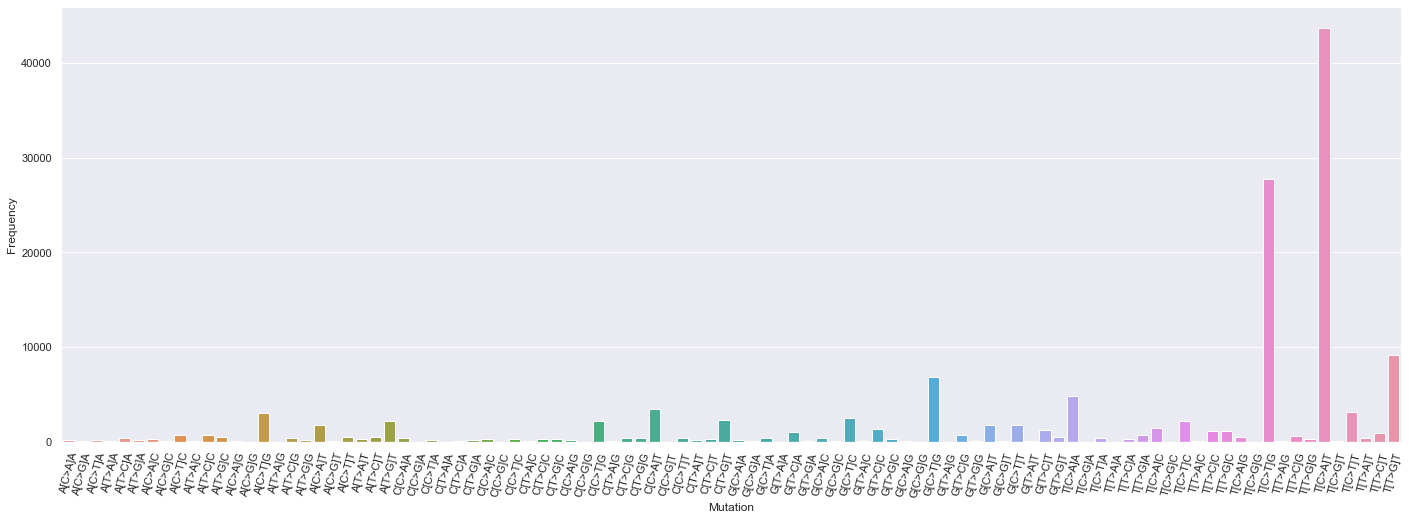

In [30]:
# Graph barplot of a cluster 
import seaborn as sns

df_cluster_profile = pd.read_csv("cluster2.csv")

sns.set(rc = {'figure.figsize':(24,8)})
plt.xticks(rotation=75)
# sns.set(font_scale = 1.7)
sns.barplot(df_cluster_profile['Mutation'], df_cluster_profile['Frequency'])

(391, 2)


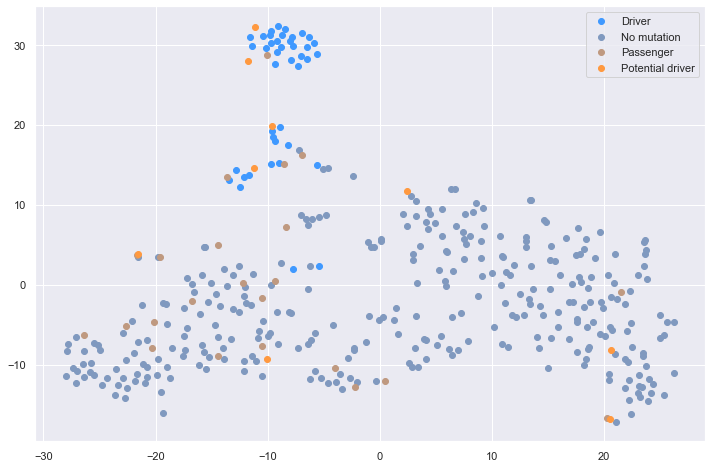

In [31]:
project_signature_distribution(df_samp_group1, "PredPOLEDriverLabel", perplexity=20)

(391, 2)


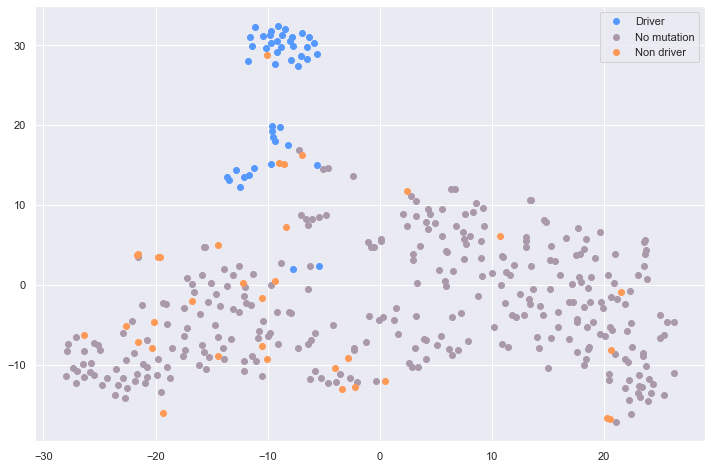

In [33]:
project_signature_distribution(df_samp_group1, 'ExpPOLEDriverLabel', perplexity=20)

## POLE Analysis 

In [ ]:
# graph_mutsig_exposure_by_label(df_POLE, "Driver")
# graph_mutsig_exposure_by_label(df_POLE, "Potential driver")
# graph_mutsig_exposure_by_label(df_POLE, "Passenger")

## combine the signatures that are related to pole aetiology -> first find the signatures 
## Get plot: Query location is shown as a black square on the cluster map of cancer sample profiles.
# Project the X-dimension (x=number of sigfnatures) exposure data for each sample. Do dimensionality reduction to visualize on the data on the 2D space. 
## - tSNE (cluster plot seen on MutaGene)

## + signature from cell paper 

(82, 2)


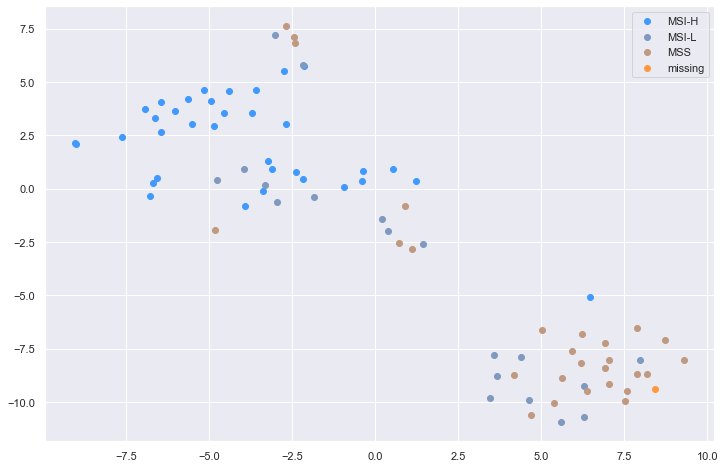

In [34]:
project_signature_distribution(df_POLE, 'MSI', perplexity=20)

(82, 2)


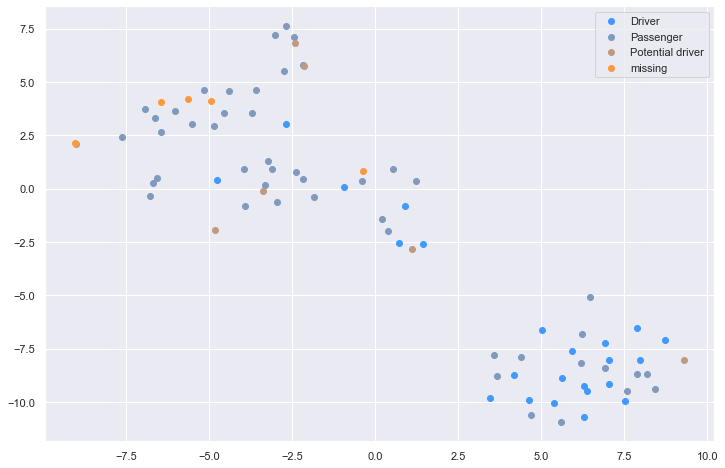

In [35]:
project_signature_distribution(df_POLE, 'label', perplexity=20)

(82, 2)


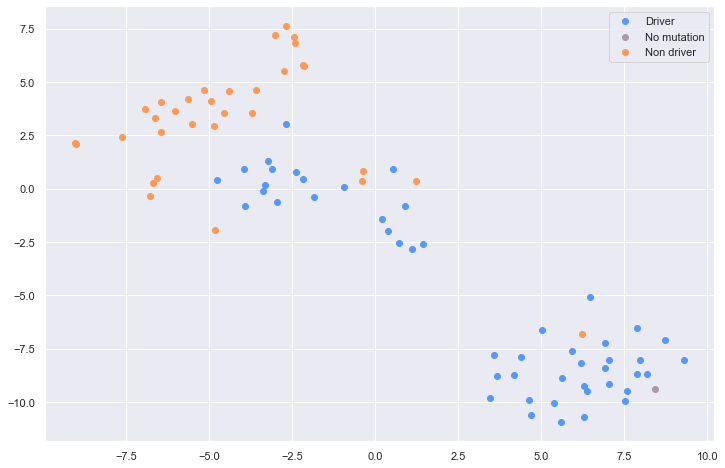

In [36]:
project_signature_distribution(df_POLE, 'ExpPOLEDriverLabel', perplexity=20)

In [39]:
# f = find_mutation_by_signature(df_POLE, "COSMICv3-SBS6")
# f.head(10)
# f.loc['P286R']

In [40]:
# f = find_mutation_by_signature(df_POLE, "COSMICv3-SBS1")
# f.head(10)

In [41]:
# f = find_mutation_by_signature(df_POLE, "COSMICv3-SBS14")
# f.head(10)

## POLD1 Analysis 

number of rows = 0 for this label. 
<class 'pandas.core.frame.DataFrame'>


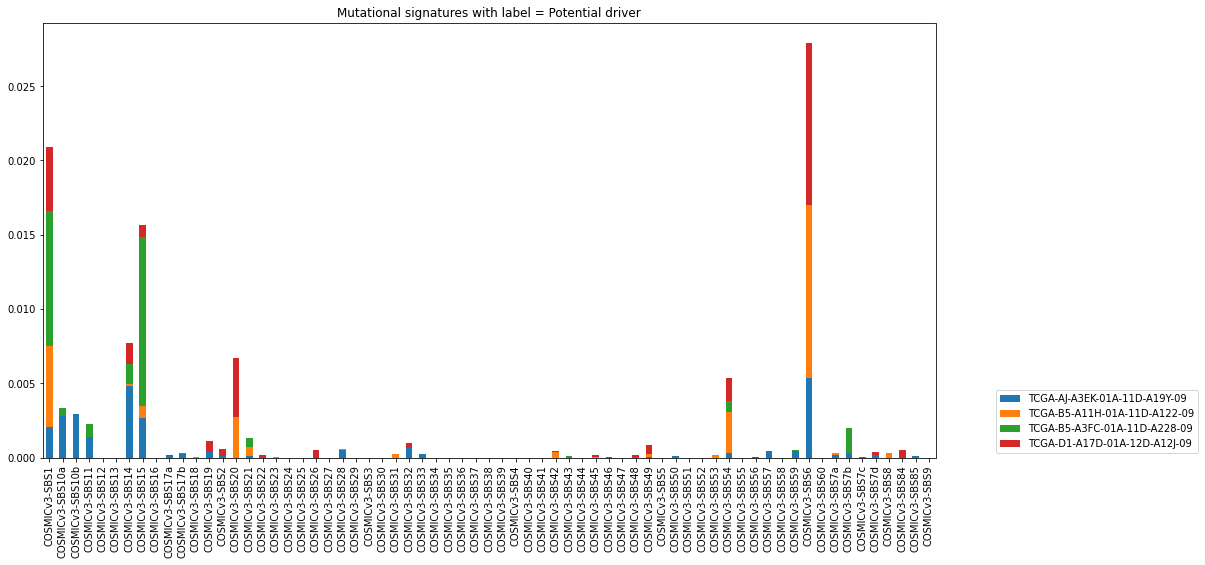

<class 'pandas.core.frame.DataFrame'>


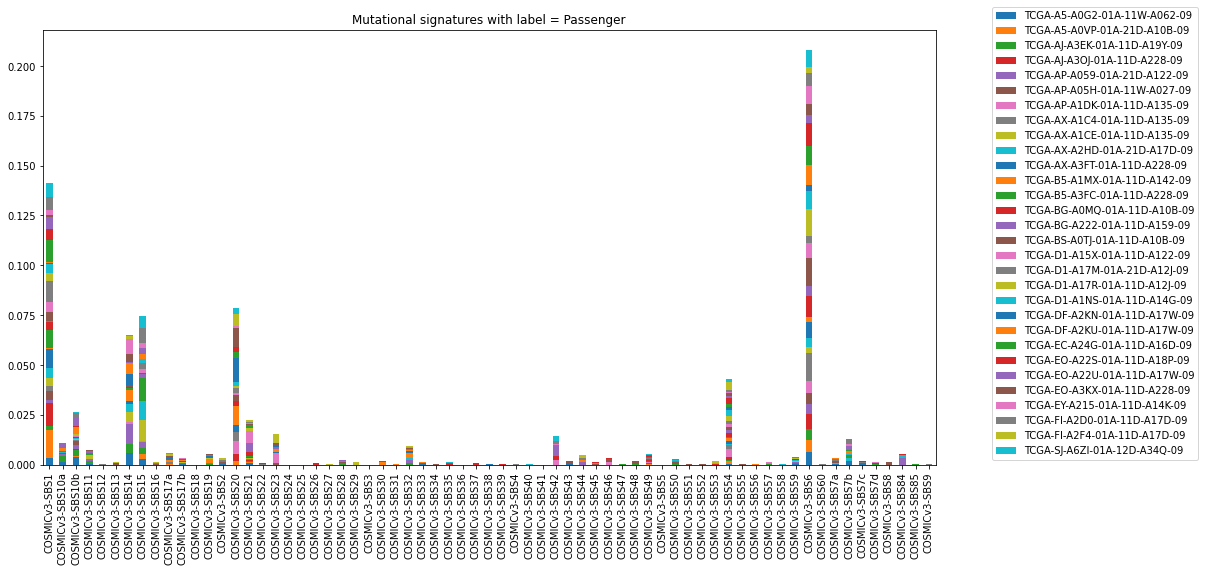

In [27]:
graph_mutsig_exposure_by_label(df_POLD1, "Driver")
graph_mutsig_exposure_by_label(df_POLD1, "Potential driver")
graph_mutsig_exposure_by_label(df_POLD1, "Passenger")

- Barplot for MSI-H/MSI-L status only samples. (current MSI status from TCGA maftools/bioconductor) 
- TCGA biolinks (from experimental data)
    - For UCEC samples and the POLE samples 

(36, 2)


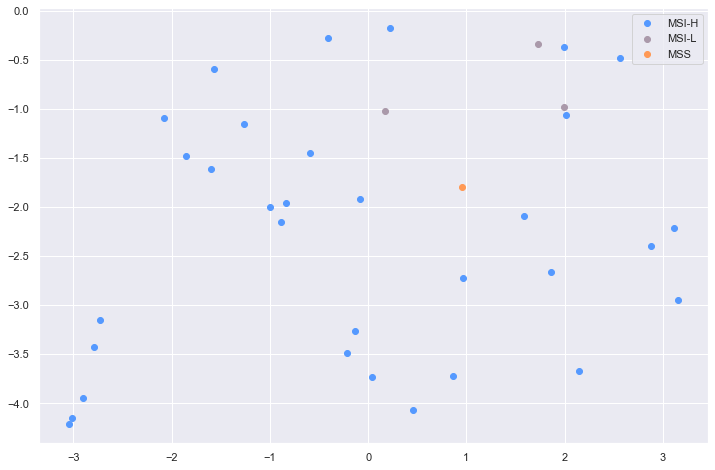

In [42]:
project_signature_distribution(df_POLD1, 'MSI', perplexity=20)

(36, 2)


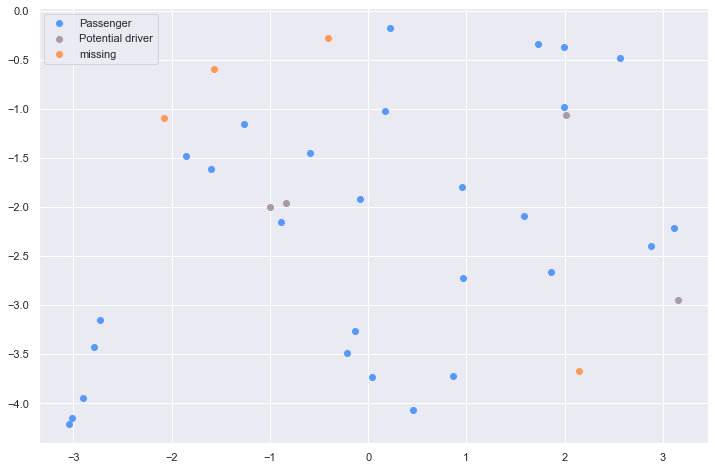

In [43]:
project_signature_distribution(df_POLD1, 'label', perplexity=20)

(36, 2)


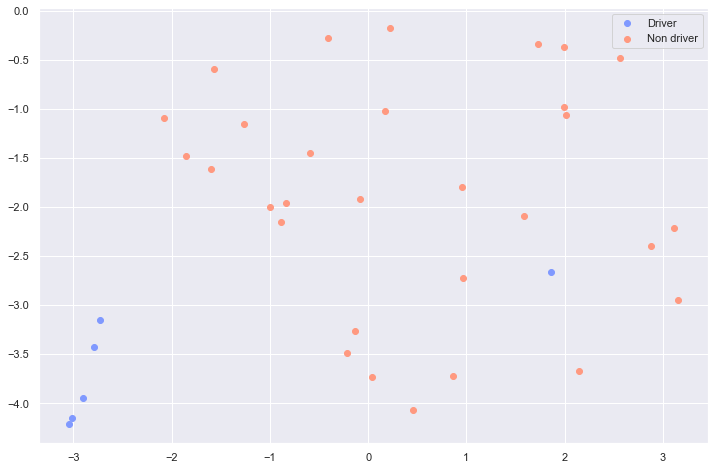

In [44]:
project_signature_distribution(df_POLD1, 'ExpPOLD1DriverLabel', perplexity=20)

In [45]:
# f = find_mutation_by_signature(df_POLD1, "COSMICv3-SBS6")
# f.head(10)

In [46]:
# f = find_mutation_by_signature(df_POLD1, "COSMICv3-SBS1")
# f.head(10)